## Load the dataset

Dataset homepage can be found [here](https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb).

In [1]:
import pandas as pd
import os

data_url = "https://hf.co/datasets/sayakpaul/genre-classification-imdb/resolve/main"

train_df = pd.read_csv(
    os.path.join(data_url, "train_data.txt"),
    engine="python",
    sep=" ::: ",
    names=["id", "movie", "genre", "summary"],
)

test_df = pd.read_csv(
    os.path.join(data_url, "test_data_solution.txt"),
    engine="python",
    sep=" ::: ",
    names=["id", "movie", "genre", "summary"],
)

print(f"Number of training samples: {len(train_df)}.")
print(f"Number of test examples: {len(test_df)}.")

Number of training samples: 54214.
Number of test examples: 54200.


In [2]:
train_df.head()

,id,movie,genre,summary
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


## Info on the sequence length

In [3]:
def get_seq_len(x):
    return len(x.split())


train_df["summary"].apply(get_seq_len).describe()

count    54214.000000
mean       101.907386
std         76.579192
min          6.000000
25%         55.000000
50%         79.000000
75%        121.000000
max       1829.000000
Name: summary, dtype: float64

## Data preparation utilities

In [4]:
from tensorflow import keras
import tensorflow as tf

auto = tf.data.AUTOTUNE
batch_size = 128


def initialize_encoders(padding_len=None):
    text_vectorizer = keras.layers.TextVectorization(
        output_sequence_length=padding_len if padding_len else None
    )
    text_vectorizer.adapt(train_df["summary"])

    label_encoder = keras.layers.StringLookup(vocabulary=train_df["genre"].unique())
    return text_vectorizer, label_encoder


def preprocess_single_row(padding_len):
    text_vectorizer, label_encoder = initialize_encoders(padding_len)

    def fn(summary, label):
        summary = text_vectorizer(summary)
        label = label_encoder(label)
        return summary, label

    return fn


def prepare_dataset(dataframe, padding_len):
    preproc_fn = preprocess_single_row(padding_len=padding_len)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summary"].values, dataframe["genre"].values)
    )
    dataset = dataset.map(preproc_fn, num_parallel_calls=auto)
    dataset = (
        dataset.batch(batch_size) if padding_len else dataset.padded_batch(batch_size)
    )
    return dataset.prefetch(auto)

## Prepare `tf.data.Dataset` objects

In [5]:
training_dataset = prepare_dataset(train_df, padding_len=None)
test_dataset = prepare_dataset(test_df, padding_len=None)

## Check out the maximum sequence lengths per batch

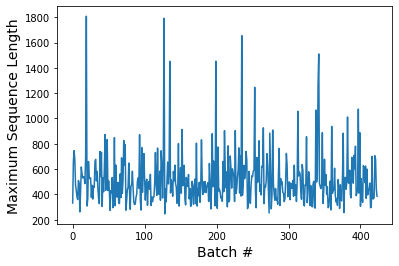

In [6]:
import matplotlib.pyplot as plt

train_seq_len = []

for text_batch, label_batch in training_dataset:
    train_seq_len.append(int(text_batch.shape[1]))

plt.plot(train_seq_len)
plt.xlabel("Batch #", fontsize=14)
plt.ylabel("Maximum Sequence Length", fontsize=14)
plt.show()

## Modeling & training utilities for $GPT-5$

In [7]:
import time

text_vectorizer, label_encoder = initialize_encoders()


def get_gpt_5():
    inputs = keras.Input(shape=(None,), dtype="int64")
    x = keras.layers.Embedding(
        input_dim=text_vectorizer.vocabulary_size(),
        output_dim=16,
    )(inputs)

    x = keras.layers.Bidirectional(keras.layers.GRU(8))(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    outputs = keras.layers.Dense(label_encoder.vocabulary_size(), activation="softmax")(
        x
    )
    gpt_5 = keras.Model(inputs, outputs)
    return gpt_5


initial_model = get_gpt_5()
initial_model.save_weights("initial_model.h5")

In [8]:
epochs = 5


def train_model(padding_len=None):
    training_dataset = prepare_dataset(train_df, padding_len=padding_len)
    test_dataset = prepare_dataset(test_df, padding_len=padding_len)

    model = get_gpt_5()
    model.load_weights("initial_model.h5")
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )

    start_time = time.time()
    history = model.fit(training_dataset, validation_data=test_dataset, epochs=epochs)
    end_time = time.time()
    total_time = end_time - start_time
    return history, total_time


def plot_loss(history):
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

## Train a model with variable max sequence length

Epoch 1/5
424/424 [==============================] - 79s 174ms/step - loss: 2.1518 - accuracy: 0.3758 - val_loss: 1.8917 - val_accuracy: 0.4495
Epoch 2/5
424/424 [==============================] - 17s 41ms/step - loss: 1.6913 - accuracy: 0.4896 - val_loss: 1.8570 - val_accuracy: 0.4642
Epoch 3/5
424/424 [==============================] - 17s 41ms/step - loss: 1.4030 - accuracy: 0.5750 - val_loss: 2.0569 - val_accuracy: 0.4356
Epoch 4/5
424/424 [==============================] - 17s 41ms/step - loss: 1.1958 - accuracy: 0.6342 - val_loss: 2.3276 - val_accuracy: 0.3589
Epoch 5/5
424/424 [==============================] - 17s 41ms/step - loss: 1.0101 - accuracy: 0.6868 - val_loss: 2.5519 - val_accuracy: 0.4115
Total training time: 148.74 seconds.


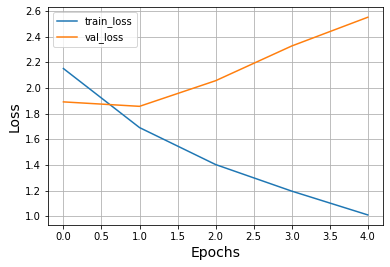

In [9]:
history_var_seqlen, total_time_var_seqlen = train_model(padding_len=None)
print(f"Total training time: {total_time_var_seqlen:.2f} seconds.")
plot_loss(history_var_seqlen)

## Train a model with fixed max sequence length

Epoch 1/5
424/424 [==============================] - 89s 201ms/step - loss: 2.1611 - accuracy: 0.3739 - val_loss: 1.9052 - val_accuracy: 0.4481
Epoch 2/5
424/424 [==============================] - 52s 123ms/step - loss: 1.6985 - accuracy: 0.4888 - val_loss: 1.8428 - val_accuracy: 0.4679
Epoch 3/5
424/424 [==============================] - 52s 123ms/step - loss: 1.3981 - accuracy: 0.5770 - val_loss: 2.0430 - val_accuracy: 0.4491
Epoch 4/5
424/424 [==============================] - 52s 123ms/step - loss: 1.1957 - accuracy: 0.6324 - val_loss: 2.3402 - val_accuracy: 0.3523
Epoch 5/5
424/424 [==============================] - 52s 123ms/step - loss: 1.0191 - accuracy: 0.6838 - val_loss: 2.4492 - val_accuracy: 0.4192
Total training time: 297.60 seconds.


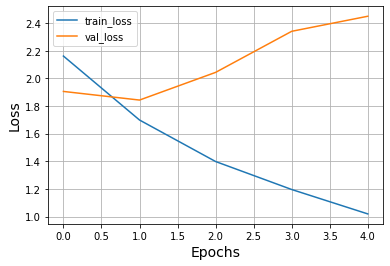

In [10]:
max_seqlen = int(train_df["summary"].apply(get_seq_len).describe()["max"])
history_var_seqlen, total_time_var_seqlen = train_model(padding_len=max_seqlen)
print(f"Total training time: {total_time_var_seqlen:.2f} seconds.")
plot_loss(history_var_seqlen)

## Further stuff

If you want to apply same principles to more advanced models like BERT, consider checking out the following repository: [carted/handling-variable-length-text-tf](https://github.com/carted/handling-variable-length-text-tf). 

